In [39]:
import pandas as pd
import numpy as np
import pickle
import nltk
import random
from sklearn.model_selection import train_test_split
from pre_processing.textProcessing import TextPreProcessor
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from wordcloud import WordCloud

def evaluate_classifier(y_true, y_pred, print_result=False):
    """
    Given a predicted and true value, get the performance measurement of the classifier
    """
    accr=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true,y_pred)
    recall=recall_score(y_true,y_pred)
    pct_maj = max(np.mean(y_true), 1-np.mean(y_true))
    
    if print_result:
        print(f"% majority class: {pct_maj}, Accuracy: {accr}, Precision: {precision}, Recall: {recall}")
    return (pct_maj, accr, precision, recall)

def undersample_data(X_train, y_train):
    """
    Undersample data
    """
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

def get_model_output(model, X_train, Y_train, X_test, Y_test, model_name='', y_labels=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], undersample=False):
    """
    Automated the training and performance of traditional ML models
    """
    output = pd.DataFrame(columns=['model_name', 'label','undersampled','pct_maj_class','accr','precision','recall'])
    for label in y_labels:
        # Get the label to use
        y_train = Y_train[label]
        y_test = Y_test[label]
        
        if undersample:
            X, y = undersample_data(X_train, y_train)
        else:
            X, y = X_train, y_train
  
        # Fit the model
        fitted = model.fit(X, y)
        pred = fitted.predict(X_test)
        
        # Get the results
        result = [model_name, label, undersample] + list(evaluate_classifier(y_true=y_test, y_pred=pred))
        output.loc[len(output)] = result
    return output

## Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')

# Sample the data
# train = train.sample(10000, random_state=1)
labels = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

## Traning and testing split
random.seed(923)

X_train, X_test, Y_train, Y_test = train_test_split(train.comment_text, labels, test_size = 0.25,random_state = 23)

X_train.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
Y_train.reset_index(drop = True,inplace = True)
Y_test.reset_index(drop = True,inplace = True)

print(f"Shape of the training set: {X_train.shape}")
print(f"Shape of the testing set: {X_test.shape}")

Shape of the training set: (119678,)
Shape of the testing set: (39893,)


In [3]:
Y_train.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## EDA

In [ ]:
# train.describe()
# classified = train.iloc[:, 2:].sum(axis=1)
# # Check for records that have no classifications and data imbalance
# train['empty_cat'] = (classified == 0)
# train['empty_cat'] = train['empty_cat'].astype(int)


# def wordcloud(column, colormap, value = True):
#     if value: 
#         subset = train[train[column] == value]
#     else: 
#         subset = train[train[column] == 1]
#     text = subset.comment_text.values
    
# #     image_path = './input/images/'+image
# #     my_mask = np.array(Image.open(image_path))
# #     my_mask = my_mask[:,:,1]
    
#     word = WordCloud(width = 1400, height =800,
#                     background_color = 'white',
#                     #mask = my_mask,
#                     max_words = 3000,
#                     random_state = 50,
#                     #scale  = 2 
#                     ).generate(' '.join(text))
#     plt.axis('off')
#     plt.title(f'High frequency words in {column.title()} Comments', fontsize = 20)
#     plt.imshow(word.recolor(colormap = colormap, random_state = 17))
    
# plt.figure(figsize = (12,12))
# wordcloud('empty_cat', 'viridis')

In [ ]:
# plt.figure(figsize = (12,12))
# wordcloud('threat', 'Wistia', False)

In [42]:
print('Number of Labels by Label')
label_count = train.iloc[:, 2:].sum()
label_count

Number of Labels by Label


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
empty_cat            0
dtype: int64

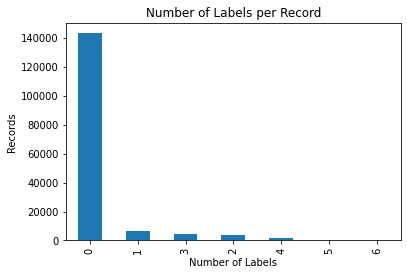

In [43]:
# Check for records that have multiple classifications
classified = train.iloc[:, 2:].sum(axis=1)

mult_class = classified.value_counts()

mult_class.plot(x=mult_class, 
             y=mult_class.values, 
             kind='bar', 
             xlabel='Number of Labels', 
             ylabel='Records')
plt.title('Number of Labels per Record')

pass

Text(0.5, 1.0, 'Number of Labels by Label')

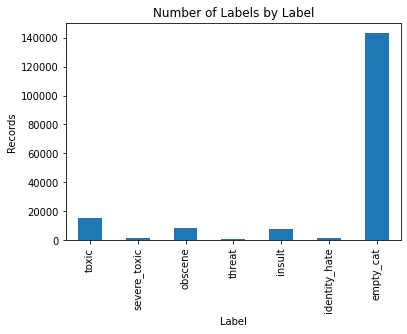

In [44]:
# Check for records that have no classifications and data imbalance
train['empty_cat'] = (classified == 0)
train['empty_cat'] = train['empty_cat'].astype(int)
 
cat_tot = train.iloc[:, 2:].sum()

cat_tot.plot(x=cat_tot, 
             y=cat_tot.values, 
             kind='bar', 
             xlabel='Label', 
             ylabel='Records')
plt.title('Number of Labels by Label')

In [45]:
print('Total comments:', len(train))
print('Total nontoxic comments:', train['empty_cat'].sum())
print('Total toxic comments:', len(train) - train['empty_cat'].sum())
print('Total labels:' , train.loc[:, 'toxic':'identity_hate'].sum().sum())

Total comments: 159571
Total nontoxic comments: 143346
Total toxic comments: 16225
Total labels: 35098


## Pre-processing

In this section, we will pre-process the data into two kinds of formats:

1. Document-Term Matrix
2. Padded numeric sequences

We will use the DTM for non RNN models, and the padded numeric sequences for recurrent neural net work based models

### Processing the documents into DTMs

In [4]:
def tokenize(text):
    """
    Define a function that take in a text and process the doc
    """
    return TextPreProcessor(text=text, lemma_flag=True, stem_flag=False).process()

# Fit a tf-idf vectorizer and filter-out the terms with less than 15 occurances or appears in more than 90% of the documents 
vec_tfidf = TfidfVectorizer(ngram_range=(1,1),tokenizer=tokenize,min_df=15, max_df=0.9)
vec_tfidf_fitted = vec_tfidf.fit(X_train)

/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [5]:
X_train_DTM = vec_tfidf_fitted.transform(X_train)
X_test_DTM = vec_tfidf_fitted.transform(X_test)

In [6]:
pd.DataFrame(X_train_DTM.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,11275,11276,11277,11278,11279,11280,11281,11282,11283,11284
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.304312,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.057764,0.0,0.0,0.0,0.0,0.116291,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Processing the documents into padded sequences

In [7]:
VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 150
# Create the tokenizer
t = Tokenizer()
# Fit the tokenizer on the documents
t.fit_on_texts(X_train)

"""
The word index for keras Tokenizer is ordered based on frequency. Therefore we can do the following according to
https://github.com/keras-team/keras/issues/8092
"""
t.oov_token = '_unknown_'
t.word_index = {e:i for e,i in t.word_index.items() if i <= VOCAB_SIZE} # <= because tokenizer is 1 indexed
t.word_index[t.oov_token] = VOCAB_SIZE + 1

"""
Apply the tokenizer
"""
encoded_docs = t.texts_to_sequences(X_train)

"""
Padd the sequences
"""
padded_docs = pad_sequences(encoded_docs, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

print("Original text:")
print(X_train[0])
print("Vectorized:")
print(encoded_docs[0])
print("Padded:")
print(padded_docs[0])

Original text:
That's correct. A smaller diameter is held less securely by the sphincter, and is less efficient at allowing gas through.
Vectorized:
[203, 365, 5, 2894, 5001, 8, 1603, 460, 5001, 31, 1, 5001, 4, 8, 460, 5001, 34, 2946, 2853, 334]
Padded:
[ 203  365    5 2894 5001    8 1603  460 5001   31    1 5001    4    8
  460 5001   34 2946 2853  334    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

## Modeling

### Multinomial Naive Bayes Classifier

In [46]:
model = MultinomialNB()
non_undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Naive Bayes',
    undersample=False
)

undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Naive Bayes',
    undersample=True
)

multi_nb_results = non_undersampled.append(undersampled, ignore_index=True)
multi_nb_results

/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,Naive Bayes,toxic,False,0.903216,0.946407,0.933132,0.480704
1,Naive Bayes,severe_toxic,False,0.989748,0.989823,0.565217,0.031785
2,Naive Bayes,obscene,False,0.947785,0.970797,0.918033,0.483917
3,Naive Bayes,threat,False,0.997218,0.997218,0.000000,0.000000
4,Naive Bayes,insult,False,0.950844,0.966611,0.848283,0.390617
5,Naive Bayes,identity_hate,False,0.990926,0.990976,0.750000,0.008287
6,Naive Bayes,toxic,True,0.903216,0.881333,0.443959,0.895623
7,Naive Bayes,severe_toxic,True,0.989748,0.920588,0.112391,0.977995
8,Naive Bayes,obscene,True,0.947785,0.890658,0.314020,0.923668
9,Naive Bayes,threat,True,0.997218,0.907202,0.027624,0.945946


### Logicstic Regression

In [47]:
non_undersampled = get_model_output(
    LogisticRegression(), 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Logistic Regression',
    undersample=False
)

undersampled = get_model_output(
    LogisticRegression(), 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Logistic Regression',
    undersample=True
)

logicstic_regression_results = non_undersampled.append(undersampled, ignore_index=True)

/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

In [48]:
logicstic_regression_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,Logistic Regression,toxic,False,0.903216,0.957612,0.918596,0.616680
1,Logistic Regression,severe_toxic,False,0.989748,0.989873,0.513966,0.224939
2,Logistic Regression,obscene,False,0.947785,0.977715,0.903924,0.641383
3,Logistic Regression,threat,False,0.997218,0.997142,0.411765,0.063063
4,Logistic Regression,insult,False,0.950844,0.971173,0.826227,0.523712
5,Logistic Regression,identity_hate,False,0.990926,0.991653,0.655914,0.168508
6,Logistic Regression,toxic,True,0.903216,0.921941,0.562406,0.871795
7,Logistic Regression,severe_toxic,True,0.989748,0.957135,0.183763,0.924205
8,Logistic Regression,obscene,True,0.947785,0.956534,0.551399,0.898704
9,Logistic Regression,threat,True,0.997218,0.946933,0.042009,0.828829


### Linear SVC

In [49]:
model = LinearSVC()
non_undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Linear SVC',
    undersample=False
)

undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Linear SVC',
    undersample=True
)

svc_results = non_undersampled.append(undersampled, ignore_index=True)
svc_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,Linear SVC,toxic,False,0.903216,0.960344,0.874220,0.689459
1,Linear SVC,severe_toxic,False,0.989748,0.989547,0.479167,0.224939
2,Linear SVC,obscene,False,0.947785,0.978718,0.862941,0.704273
3,Linear SVC,threat,False,0.997218,0.997293,0.542857,0.171171
4,Linear SVC,insult,False,0.950844,0.971624,0.782165,0.585926
5,Linear SVC,identity_hate,False,0.990926,0.992029,0.652778,0.259669
6,Linear SVC,toxic,True,0.903216,0.913945,0.533385,0.885522
7,Linear SVC,severe_toxic,True,0.989748,0.945880,0.153053,0.943765
8,Linear SVC,obscene,True,0.947785,0.949289,0.507970,0.917907
9,Linear SVC,threat,True,0.997218,0.942321,0.042224,0.909910


### Random Forest

In [50]:
model = RandomForestClassifier(n_estimators=200)
non_undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Random Forest (200 trees)',
    undersample=False
)

undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Random Forest (200 trees)',
    undersample=True
)

rf_results = non_undersampled.append(undersampled, ignore_index=True)
rf_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,Random Forest (200 trees),toxic,False,0.903216,0.954754,0.910543,0.590521
1,Random Forest (200 trees),severe_toxic,False,0.989748,0.989948,0.586957,0.066015
2,Random Forest (200 trees),obscene,False,0.947785,0.979595,0.891909,0.693231
3,Random Forest (200 trees),threat,False,0.997218,0.997293,0.714286,0.045045
4,Random Forest (200 trees),insult,False,0.950844,0.969518,0.792157,0.515043
5,Random Forest (200 trees),identity_hate,False,0.990926,0.991126,0.586957,0.074586
6,Random Forest (200 trees),toxic,True,0.903216,0.888978,0.459602,0.836830
7,Random Forest (200 trees),severe_toxic,True,0.989748,0.904645,0.092241,0.938875
8,Random Forest (200 trees),obscene,True,0.947785,0.923972,0.397497,0.884301
9,Random Forest (200 trees),threat,True,0.997218,0.883914,0.021592,0.918919


In [51]:
rf_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,Random Forest (200 trees),toxic,False,0.903216,0.954754,0.910543,0.590521
1,Random Forest (200 trees),severe_toxic,False,0.989748,0.989948,0.586957,0.066015
2,Random Forest (200 trees),obscene,False,0.947785,0.979595,0.891909,0.693231
3,Random Forest (200 trees),threat,False,0.997218,0.997293,0.714286,0.045045
4,Random Forest (200 trees),insult,False,0.950844,0.969518,0.792157,0.515043
5,Random Forest (200 trees),identity_hate,False,0.990926,0.991126,0.586957,0.074586
6,Random Forest (200 trees),toxic,True,0.903216,0.888978,0.459602,0.836830
7,Random Forest (200 trees),severe_toxic,True,0.989748,0.904645,0.092241,0.938875
8,Random Forest (200 trees),obscene,True,0.947785,0.923972,0.397497,0.884301
9,Random Forest (200 trees),threat,True,0.997218,0.883914,0.021592,0.918919


### XGboost

In [52]:
model = XGBClassifier(n_estimators=200)
non_undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='XGBoost (200 trees)',
    undersample=False
)

undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='XGBoost (200 trees)',
    undersample=True
)

xgb_results = non_undersampled.append(undersampled, ignore_index=True)
xgb_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,XGBoost (200 trees),toxic,False,0.903216,0.958238,0.902457,0.637400
1,XGBoost (200 trees),severe_toxic,False,0.989748,0.989672,0.493213,0.266504
2,XGBoost (200 trees),obscene,False,0.947785,0.980448,0.863358,0.743159
3,XGBoost (200 trees),threat,False,0.997218,0.997318,0.545455,0.216216
4,XGBoost (200 trees),insult,False,0.950844,0.971850,0.777116,0.599184
5,XGBoost (200 trees),identity_hate,False,0.990926,0.992079,0.629213,0.309392
6,XGBoost (200 trees),toxic,True,0.903216,0.921665,0.562373,0.859363
7,XGBoost (200 trees),severe_toxic,True,0.989748,0.941042,0.138444,0.909535
8,XGBoost (200 trees),obscene,True,0.947785,0.958815,0.565632,0.910226
9,XGBoost (200 trees),threat,True,0.997218,0.906174,0.024358,0.837838


### Neural Network

In [15]:
"""
Model 1: Bidirectional LSTM - not undersampled
"""
def create_model(vocab_size, num_labels, sequence_length):
    model = tf.keras.Sequential([
        layers.Input(shape=(sequence_length,)),
        layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=sequence_length, mask_zero=True),
        layers.Dropout(0.4),
        layers.Bidirectional(layers.LSTM(64,return_sequences = False,dropout = 0.2,recurrent_dropout = 0.2)),
        layers.Dense(25,activation = 'relu'),
        layers.Dense(num_labels,activation = 'sigmoid')
    ])
    return model

model = create_model(len(t.word_index)+1, num_labels=6, sequence_length=MAX_SEQUENCE_LENGTH)
model.compile(
    loss=losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

from keras.callbacks import EarlyStopping
# Define an early-stopping callback
cb = [EarlyStopping(monitor='val_loss',patience = 2)]

batch_size = 32
num_epochs = 20

model.fit(padded_docs, Y_train,validation_split=0.2,\
          batch_size=batch_size, epochs=num_epochs,verbose=1,callbacks =cb)

2022-07-30 01:53:18.580360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
2992/2992 [==============================] - 647s 215ms/step - loss: 0.0777 - accuracy: 0.9602 - val_loss: 0.0563 - val_accuracy: 0.9939
Epoch 2/20
2992/2992 [==============================] - 626s 209ms/step - loss: 0.0533 - accuracy: 0.9940 - val_loss: 0.0533 - val_accuracy: 0.9939
Epoch 3/20
2992/2992 [==============================] - 624s 209ms/step - loss: 0.0500 - accuracy: 0.9940 - val_loss: 0.0529 - val_accuracy: 0.9939
Epoch 4/20
2992/2992 [==============================] - 628s 210ms/step - loss: 0.0479 - accuracy: 0.9938 - val_loss: 0.0533 - val_accuracy: 0.9938
Epoch 5/20
2992/2992 [==============================] - 627s 209ms/step - loss: 0.0463 - accuracy: 0.9884 - val_loss: 0.0530 - val_accuracy: 0.9937


In [16]:
encoded_doc_test = t.texts_to_sequences(X_test)
padded_doc_test = pad_sequences(encoded_doc_test, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
pred = model.predict(padded_doc_test)

"""
Construct the final model
"""
model_name = 'Bi-LSTM + Embedding'
undersampled = False
bilstm_results = pd.DataFrame(columns=['model_name', 'label','undersampled','pct_maj_class','accr','precision','recall'])
for i in range(6):
    y_pred_bin = [x>0.5 for x in pred[:,i]]
    label = Y_train.columns[i]
    y_test = Y_test
    result = [model_name, label, undersampled] + list(evaluate_classifier(y_true=y_test.iloc[:,i], y_pred=y_pred_bin))
    bilstm_results.loc[len(bilstm_results)] = result

1247/1247 [==============================] - 33s 26ms/step


/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
bilstm_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,Bi-LSTM + Embedding,toxic,False,0.903216,0.961221,0.830950,0.752396
1,Bi-LSTM + Embedding,severe_toxic,False,0.989748,0.990099,0.526316,0.342298
2,Bi-LSTM + Embedding,obscene,False,0.947785,0.980999,0.849604,0.772924
3,Bi-LSTM + Embedding,threat,False,0.997218,0.997218,0.000000,0.000000
4,Bi-LSTM + Embedding,insult,False,0.950844,0.971875,0.722783,0.694034
5,Bi-LSTM + Embedding,identity_hate,False,0.990926,0.990926,0.000000,0.000000


In [18]:
"""
Model 2: LSTM only
"""

'\nModel 2: LSTM only\n'

## Consolidate results

In [53]:
all_results = pd.concat([multi_nb_results, svc_results, logicstic_regression_results,rf_results,xgb_results,bilstm_results])

In [54]:
all_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
0,Naive Bayes,toxic,False,0.903216,0.946407,0.933132,0.480704
1,Naive Bayes,severe_toxic,False,0.989748,0.989823,0.565217,0.031785
2,Naive Bayes,obscene,False,0.947785,0.970797,0.918033,0.483917
3,Naive Bayes,threat,False,0.997218,0.997218,0.000000,0.000000
4,Naive Bayes,insult,False,0.950844,0.966611,0.848283,0.390617
...,...,...,...,...,...,...,...
1,Bi-LSTM + Embedding,severe_toxic,False,0.989748,0.990099,0.526316,0.342298
2,Bi-LSTM + Embedding,obscene,False,0.947785,0.980999,0.849604,0.772924
3,Bi-LSTM + Embedding,threat,False,0.997218,0.997218,0.000000,0.000000
4,Bi-LSTM + Embedding,insult,False,0.950844,0.971875,0.722783,0.694034


In [55]:
all_results.to_csv('../output/all_results.csv',index=False)

In [57]:
all_results[all_results.undersampled==True]

,model_name,label,undersampled,pct_maj_class,accr,precision,recall
6,Naive Bayes,toxic,True,0.903216,0.881333,0.443959,0.895623
7,Naive Bayes,severe_toxic,True,0.989748,0.920588,0.112391,0.977995
8,Naive Bayes,obscene,True,0.947785,0.890658,0.314020,0.923668
9,Naive Bayes,threat,True,0.997218,0.907202,0.027624,0.945946
10,Naive Bayes,insult,True,0.950844,0.888978,0.296973,0.920449
11,Naive Bayes,identity_hate,True,0.990926,0.898579,0.077329,0.930939
6,Linear SVC,toxic,True,0.903216,0.913945,0.533385,0.885522
7,Linear SVC,severe_toxic,True,0.989748,0.945880,0.153053,0.943765
8,Linear SVC,obscene,True,0.947785,0.949289,0.507970,0.917907
9,Linear SVC,threat,True,0.997218,0.942321,0.042224,0.909910
